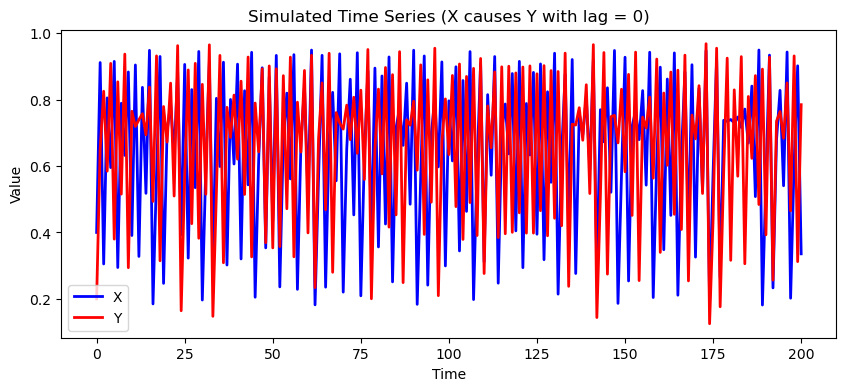

TE(pre→residual) = 0.5104 bits


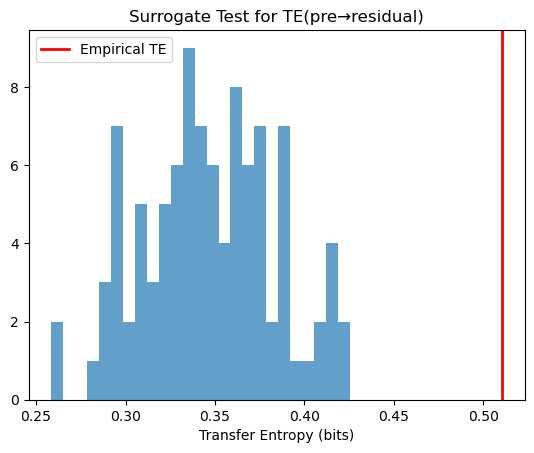

p-value = 0.000


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy  # correct import! :contentReference[oaicite:0]{index=0}



r_x = 3.8        
r_y = 3.5       
B_yx = 0.1      
LAG = 0          
t_total = 200    

X = np.zeros(t_total + 1)
Y = np.zeros(t_total + 1)
X[0] = 0.4
Y[0] = 0.2

for t in range(t_total):
    X[t+1] = r_x * X[t] * (1 - X[t])
    if (t + 1) < LAG:
        Y[t+1] = r_y * Y[t] * (1 - Y[t])
    else:
        Y[t+1] = r_y * Y[t] * (1 - Y[t]) + B_yx * X[t - LAG + 1]

time = np.arange(t_total + 1)
plt.figure(figsize=(10, 4))
plt.plot(time, X, 'b-', linewidth=2, label='X')
plt.plot(time, Y, 'r-', linewidth=2, label='Y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Simulated Time Series (X causes Y with lag = {LAG})')
plt.legend()
plt.show()


# save X and Y to csv and add a time column
df = pd.DataFrame({
    "Time": time,
    "X": X,
    "Y": Y,
})
# df.to_csv('X_Y.csv', index=False)






# — assume df_pre_aligned['pre'] and df_residual['residual'] exist and are same length
x = df['X'].values      # source (precession)
y = df['Y'].values    # target (residual)

# y = df['X'].values      # source (precession)
# x = df['Y'].values    # target (residual)

# # flip x and y upside down
# x = x[::-1]
# y = y[::-1]

# 1) Discretize into nbins equiprobable bins
nbins = 8
xbins = np.histogram_bin_edges(x, bins=nbins)
ybins = np.histogram_bin_edges(y, bins=nbins)
x_disc = np.digitize(x, xbins) - 1
y_disc = np.digitize(y, ybins) - 1

# 2) Compute TE from pre→residual with history length k=1
#    note: drop last/first sample to align t→t+1
te_xy = transfer_entropy(x_disc[:-1], y_disc[1:], k=1)
print(f"TE(pre→residual) = {te_xy:.4f} bits")

# 3) Permutation‐based surrogate test
n_surr = 100
te_null = np.zeros(n_surr)
for i in range(n_surr):
    xs = np.random.permutation(x_disc)
    te_null[i] = transfer_entropy(xs[:-1], y_disc[1:], k=1)

# 4) Plot null distribution
plt.hist(te_null, bins=25, alpha=0.7)
plt.axvline(te_xy, color='r', lw=2, label='Empirical TE')
plt.xlabel('Transfer Entropy (bits)')
plt.legend()
plt.title('Surrogate Test for TE(pre→residual)')
plt.show()

# 5) Compute p-value
p_value = np.mean(te_null >= te_xy)
print(f"p-value = {p_value:.3f}")